Initial graph setup:
Graph has 10 nodes and 17 edges


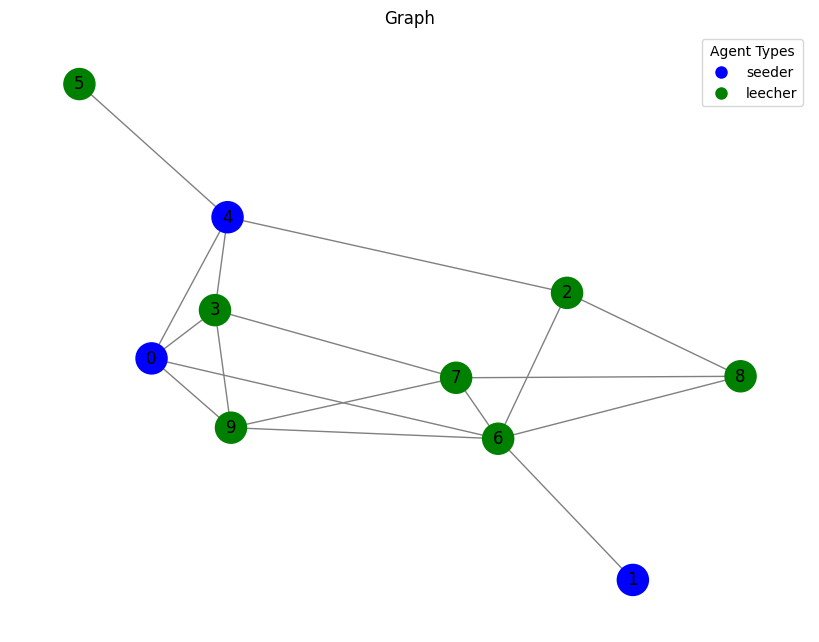

In [ ]:
import sys, os, pathlib
project_root = pathlib.Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.graph import erdos_renyi_graph
import src.agent as agent_module
from utils.plotter import draw_graph

G = erdos_renyi_graph(n=20, p=0.1)
agent_module.assign_n_seeders(G, n=2, seed=42)
print("Initial graph setup:")
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
draw_graph(G)


In [ ]:
import sys, os, pathlib
project_root = pathlib.Path.cwd().parent
sys.path.insert(0, str(project_root))

import src.agent as agent_module

FILE_PIECES = 20
agent_module.initialize_file_sharing(G, FILE_PIECES, seed=42)

print("File sharing initialized with 20 pieces:")
print("\nAgent information:")
for node in G.nodes():
    info = agent_module.get_agent_info(G, node)
    print(f"Node {node}: {info['role']} - {info['num_pieces']}/20 pieces - Complete: {info['is_complete']}")

print(f"\nTotal pieces in network: {sum(len(G.nodes[node].get('file_pieces', set())) for node in G.nodes())}")


File sharing initialized with 20 pieces:

Agent information:
Node 0: seeder - 20/20 pieces - Complete: True
Node 1: seeder - 20/20 pieces - Complete: True
Node 2: leecher - 0/20 pieces - Complete: False
Node 3: leecher - 0/20 pieces - Complete: False
Node 4: seeder - 20/20 pieces - Complete: True
Node 5: leecher - 0/20 pieces - Complete: False
Node 6: leecher - 0/20 pieces - Complete: False
Node 7: leecher - 0/20 pieces - Complete: False
Node 8: leecher - 0/20 pieces - Complete: False
Node 9: leecher - 0/20 pieces - Complete: False

Total pieces in network: 60
